# Steganography for Text - Hiding Text in Images

![](../images/daniel-gregoire-N7dsOPLDk9I-unsplash.jpg)
_Photo by [Daniel Gregoire](https://unsplash.com/@yeeeeeeha) on [Usplash](https://unsplash.com/photos/N7dsOPLDk9I)_

## What is Steganography

> [Steganography](https://en.wikipedia.org/wiki/Steganography) is the practice of concealing a file, message, image, or video within another file, message, image, or video.

Inspired by this [excellent blog post](https://towardsdatascience.com/steganography-hiding-an-image-inside-another-77ca66b2acb1) by **Kelvin Salton do Prado** explaining a simple approach for concealing one image within another image, I have created this short application to hide a text message inside a given image, without causing any noticeable change to the original image.

I have also added a nice visualization at the end capturing the whole process.

**Note: This application requires an image with 3 channels (e.g. RGB) hence grayscale images will not work**

The core idea behind this implementation is actually quite simple and the key aspects are as follows:
- Each pixel of an RGB image consists of three 8-bit values corresponding to the three channels
- Each of these three 8-bit values consist of **4 most-significant-bits (MSB) and 4 least-significant-bits (LSB)**
- Hence every pixel is a combination of **12 (4+4+4) MSBs** and **12 (4+4+4) LSBs**
- As the name suggests, the **12 LSBs** are less relevant and can be modified without any noticeable change in the image

Following are the steps involved in the hide operation:
- Read the input image into a 3D array of pixels of size **HxWxC (H=height, W=width, C=channels=3 for RGB)**
- Read the input text file and store contents into an array of bytes
- Convert every byte(character) of the text into a **12-bit binary format**
- Starting with the first pixel (n=0) of the image matrix, replace the **12 LSBs** of pixel-n with the **12-bit value** of the byte-n from the text byte-array
- Repeat above operation (n=n+1 every time) until there are no more bytes left in the text byte-array
- In the last iteration, replace the **12 LSBs** of pixel-n with a **special 12-bit `end-of-text indicator`** value
- Save the modified image matrix into a new image file

The following image should help illustrate the above steps using an example

![](../images/text_hiding.png)


Similarly, the steps involved in the unhide operation are as follows:
- Read the input image into a 3D array of pixels of size **HxWxC (H=height, W=width, C=channels=3 for RGB)**
- Starting with the first pixel (n=0) of the image matrix, read the **12 LSBs** of pixel-n and add it to a byte array
- Repeat above operation (n=n+1 every time) until you find the `end-of-text indicator` value in the **12 LSBs** of pixel-n
- Decode the byte array and save the contents into a new text file

 We start with importing the libraries we need and setting the plot mode for `inline` display

In [1]:
import base64
import cv2
import time
import imutils
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Video

%matplotlib inline

 In this script we will be using some static configuration parameters, which we wouldn't normally require to change.
 
 A special note for the parameter `eotIn` which is a special signature used to indicate the end of text.
 
 This allows the extraction logic to stop processing the image when all the text has been extracted, hence saving time.

In [2]:
# define configuration params
figureSize = (12,10) # image size for display
displayWidth = (1024+128) # max width of image for display
maxDebugBytes = 10 # max num of bytes to view in debug mode
eotInd = 2730 # '101010101010' - 12 bit End-Of-Text indicator
maxCharRange = 127 # max range of characters as per ASCII table
debugMode = False # flag to view debug prints
visHoldTime = 1 # time in milisec to hold visualization per character
visFps = 30 # frames per second for the captured visualization video
visStack = 0 # direction (0-horizontal/1-vertical) for visualization stack

 Then we move on to define the core logic of our script, the `Steganography` class and it's member functions.
 
 This class implements the hide and unhide operations along with some utility functions.

In [3]:
class Steganography(object):

    @staticmethod
    def __int_to_bin(rgb):
        """Convert an integer tuple to a binary (string) tuple.

        :param rgb: An integer tuple (e.g. (220, 110, 96))
        :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        """
        r, g, b = rgb
        return ('{0:08b}'.format(r),
                '{0:08b}'.format(g),
                '{0:08b}'.format(b))

    @staticmethod
    def __bin_to_int(rgb):
        """Convert a binary (string) tuple to an integer tuple.

        :param rgb: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :return: Return an int tuple (e.g. (220, 110, 96))
        """
        r, g, b = rgb
        return (int(r, 2),
                int(g, 2),
                int(b, 2))

    @staticmethod
    def __hide_rgb(rgb1, rgb2):
        """hide two RGB tuples.

        :param rgb1: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :param rgb2: Another string tuple
        (e.g. ("00101010", "11101011", "00010110"))
        :return: An integer tuple with the two RGB values hidden.
        """
        r1, g1, b1 = rgb1
        r2, g2, b2 = rgb2
        rgb = (r1[:4] + r2[:4],
               g1[:4] + g2[:4],
               b1[:4] + b2[:4])
        return rgb

    @staticmethod
    def hide(img, text, debug=False):
        """hide an image content with a text.

        :param img: Image file
        :param text: Text file
        :param debug: Flag for debug prints
        :return: A new hidden image.
        """
        # check is image path is valid
        if not os.path.exists(img):
          print("!! Unable to locate image file:",img)
          return False,None
        
        # check is text path is valid
        if not os.path.exists(text):
          print("!! Unable to locate text file:",text)
          return False,None

        # Load the image
        image = cv2.imread(img,cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # Clone the original image to create a copy that will contain hidden content
        new_image = image.copy()
        
        # check if image contains 3 channels, else quit
        im_shape = image.shape
        if len(im_shape) != 3:
          print("!! Unable to hide text as image does not have 3 channels !!")
          return False,new_image
        elif im_shape[2] != 3:
          print("!! Unable to hide text as image does not have 3 channels !!")
          return False,new_image
        
        # Open the text file and read the content
        fp = open(text, 'rb')
        text_bin = fp.read()
        fp.close()

        print("Length of text: {} chars".format(len(text_bin)))
        
        # check if image size is sufficient to encode full text, else quit
        required_bytes = len(text_bin) * 3
        if required_bytes > im_shape[0] * im_shape[1] * 3:
          print("!! Unable to hide full text as image does not have sufficient size !!")
          return False,new_image
        
        # initialize variables
        idx = 0
        break_flag = False

        for i in range(im_shape[0]):
            for j in range(im_shape[1]):
                rgb1 = Steganography.__int_to_bin(image[i,j])
                
                if idx == len(text_bin):
                  # if no more text left to hide, insert the end of text signature
                  bin_val = "{0:012b}".format(eotInd)
                  break_flag = True
                  if debug:
                    print("Hit end of text at idx:",idx)
                    print("No of bytes used:", idx*3)
                else:
                  if text_bin[idx] > maxCharRange:
                    # if character is out of max range, insert a 'dot' character in 12-bit binary format
                    bin_val = "{0:012b}".format(ord('.'))
                  else:
                    # convert character to 12-bit binary format
                    bin_val = "{0:012b}".format(text_bin[idx])
                  
                # split into 3 channels of 4 bits each
                rgb2 = (bin_val[:4],bin_val[4:8],bin_val[8:12])

                # hide the two pixels and convert it to a integer tuple
                rgb = Steganography.__hide_rgb(rgb1, rgb2)

                new_image[i,j] = Steganography.__bin_to_int(rgb)
                
                if debug:
                  if idx < maxDebugBytes:
                    # visualize first maxDebugBytes
                    # print(text_bin[idx])
                    # print(chr(text_bin[idx]))
                    print("bin_val[{}]:{}".format(idx,bin_val))
                
                idx += 1
                if break_flag == True:
                  break
            if break_flag == True:
              break

        plt.figure(figsize=figureSize)
        plt.imshow(imutils.resize(image,width=displayWidth))
        plt.title('Input Image')
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
        
        plt.figure(figsize=figureSize)
        plt.imshow(imutils.resize(new_image,width=displayWidth))
        plt.title('Hidden Image')
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()

        return True,new_image

    @staticmethod
    def unhide(img,visualize,videofile,debug=False):
        """Unhide an image.

        :param img: The input image.
        :param debug: Flag for debug prints
        :return: The unhidden/extracted text.
        """

        # check is image path is valid
        if not os.path.exists(img):
          print("!! Unable to locate image file:",img)
          return False,None
        
        # Load the image
        image = cv2.imread(img,cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # Store the image size
        im_shape = image.shape
        # check if image contains 3 channels, else quit
        if len(im_shape) != 3:
          print("!! Unable to extract text as image does not have 3 channels !!")
          return False,None
        elif im_shape[2] != 3:
          print("!! Unable to extract text as image does not have 3 channels !!")
          return False,None
        
        # initialize variables
        text_bin = []
        idx = 0
        break_flag = False

        # create a canvas for displaying extracted text
        text_canvas =  np.zeros_like(image)
        # create a white canvas for displaying image
        white_canvas =  255 * np.ones_like(image)
        
        video_out = None
        if visualize.lower() == 'true':
          # Define the codec and create VideoWriter object
          #fourcc = cv2.VideoWriter_fourcc(*'MP4V')
          #fourcc = cv2.VideoWriter_fourcc(*'X264')
          fourcc = cv2.VideoWriter_fourcc(*'avc1')
          # fourcc = cv2.VideoWriter_fourcc(*'XVID')
          video_width = displayWidth
          video_height = int(0.5*displayWidth*im_shape[0]/im_shape[1])
          # Open the video file
          # video_out = cv2.VideoWriter(videofile,fourcc,visFps, (im_shape[1],im_shape[0]))
          video_out = cv2.VideoWriter(videofile,fourcc,visFps, (video_width,video_height))
        
        print("Begin processing image file")
        for i in range(im_shape[0]):
            for j in range(im_shape[1]):
                # Get the RGB (as a string tuple) from the current pixel
                r, g, b = Steganography.__int_to_bin(image[i,j])

                # Extract the last 4 bits (corresponding to the hidden text)
                bin_val = r[4:] + g[4:] + b[4:]
                
                if debug:
                # view first maxDebugBytes bytes
                  if idx < maxDebugBytes:
                    print("bin_val[{}]:{}".format(idx,bin_val))

                # Convert it to an integer
                int_val = int(bin_val,2)
                if int_val == eotInd:
                  # Check if End-Of-Text indicator is found
                  if debug:
                    print("Found end of text signature at index:", idx)
                  break_flag = True
                elif int_val <= maxCharRange:
                  # only take characters within max range and append to output list
                  text_bin.append(int_val)

                  if visualize.lower() == 'true':
                    # visualize the extraction process
                    try:
                      xpos = (j*30) % im_shape[1]
                      ypos = i+30 + (j*30//im_shape[1]) * 30
                      
                      cv2.putText(text_canvas, chr(text_bin[idx]), (xpos,ypos),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0, 255, 0),4)
                      
                      # create a canvas for displaying original image while extraction with some blurring effect
                      img_canvas = image.copy()
                      img_canvas = cv2.addWeighted(img_canvas, 0.30, white_canvas, 0.70, 0)
                      # show a small moving box to indicate pixel processing
                      rectx = (j*30) % im_shape[1]
                      recty = (i + (j*30//im_shape[1]) * 30) % im_shape[0]
                      rectw = 30
                      recth = 30
                      
                      cv2.rectangle(img_canvas, (rectx, recty), (rectx+rectw, recty+recth), (0,0,255), 5)
                      
                      if idx%20 < 10:
                        # Add a blinking text effect
                        cv2.putText(img_canvas, 'Scanning Image', (int(0.6* im_shape[1]//2),im_shape[0]//2),cv2.FONT_HERSHEY_SIMPLEX,3.0,(255, 0, 0), 10)
                      
                      if visStack == 0:
                        # stack_img = np.hstack((img_canvas,text_canvas))
                        stack_img = np.hstack((imutils.resize(img_canvas,width=displayWidth//2),imutils.resize(text_canvas,width=displayWidth//2)))
                      else:
                        # stack_img = np.vstack((img_canvas,text_canvas))
                        stack_img = np.vstack((imutils.resize(img_canvas,width=displayWidth//2),imutils.resize(text_canvas,width=displayWidth//2)))

                      stack_img = cv2.cvtColor(stack_img, cv2.COLOR_RGB2BGR)
                      video_out.write(cv2.resize(stack_img,(video_width,video_height)))
                      
                    except Exception as err:
                        print("!! Visualization error:", err)
                        visualize = 'false'
                  
                  idx += 1
                  
                if break_flag == True:
                  break
            if break_flag == True:
              break

        print("Finished processing image file")
        
        if debug:
          # view first maxDebugBytes
          print("view first {} bytes".format(maxDebugBytes))
          print(text_bin[:maxDebugBytes])
          print(bytes(text_bin[:maxDebugBytes]))
          print("maxval:",max(text_bin))
          print("minval:",min(text_bin))

        if video_out != None:
          # Close the video file
          video_out.release()
        
        plt.figure(figsize=figureSize)
        plt.imshow(imutils.resize(image,width=displayWidth))
        plt.title('Original Image')
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
        try:
          plt.figure(figsize=figureSize)
          plt.imshow(imutils.resize(text_canvas,width=displayWidth))
          plt.title('Unhidden Text')
          plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
          plt.show()
          text_data = bytes(text_bin).decode()
          print("Unhidden Text:")
          print("===================================")
          print(text_data)
          print("===================================")
        
        except Exception as err:
          print("!! Decode Error:",err)

        return True,bytes(text_bin)

 With the core logic defined, we will now define a simple driver function to invoke the hide operation.
 
 This function accepts the required inputs, calls the hide function and saves the output image

In [4]:
def hide(img, text, output):
    start_time = time.time()
    ret_val,hidden_image = Steganography.hide(img,text,debugMode)
    end_time = time.time()
    
    if not ret_val:
      print("!! hide Failure !!")
      return
    print("Total time taken for hide: {:0.02f}s".format(end_time-start_time))
    
    hidden_image = cv2.cvtColor(hidden_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output,hidden_image)

 We will configure the input parameters for the hide operation, providing the names of the input image and text files along with the output image file.
 
 I have configured them as per some sample files which are included as part of this demonstration.
 
 **You can change these values as per your choice of image and text content.**

In [5]:
img = '../images/img1.jpg'
text = '../images/text1.txt'
output = '../images/output.png'

 We are now ready to perform the hide operation

Length of text: 1444 chars


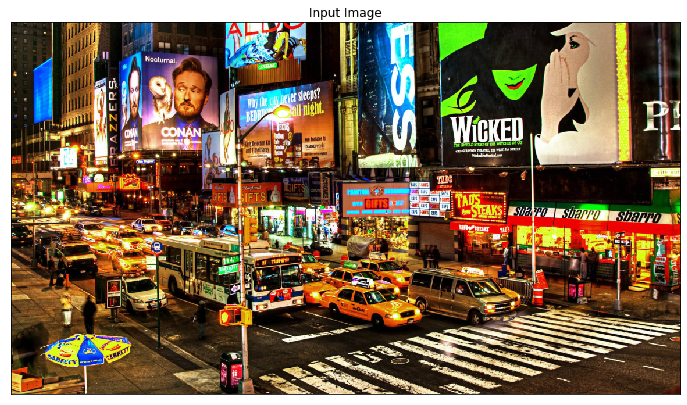

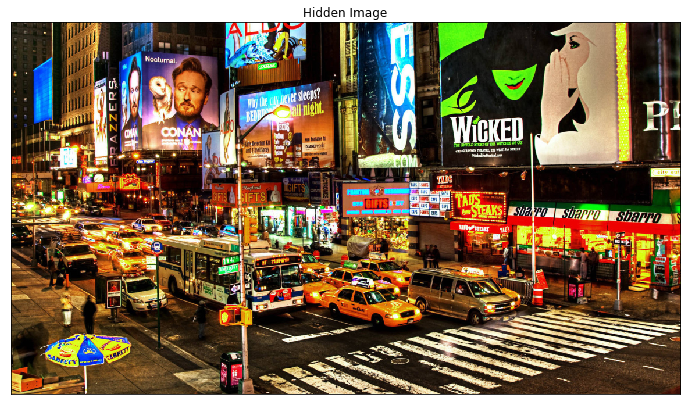

Total time taken for hide: 0.63s


In [6]:
hide(img,text,output)

As you can see above, it is hard for the human eye to distinguish between the original and the merged image containing the text hidden inside.
 
Next, we will define a driver function to extract this hidden text from the image.

This simple function will accept the required inputs, call the extract function and save the extracted text in the file name that we provided.

In [7]:
def unhide(img, output, visualize, videofile):
    start_time = time.time()
    ret_val,unhidden_text = Steganography.unhide(img,visualize,videofile,debugMode)
    end_time = time.time()
    
    if not ret_val:
      print("!! Unhide Failure !!")
      return
    
    print("Total time taken for unhide: {:0.02f}s".format(end_time-start_time))
    
    fp = open(output,'wb')
    fp.write(unhidden_text)
    fp.close()

We will configure our input parameters as before, providing the input image and output text file along with some parameters to control if a visualization video is generated for the extraction process.
 
**Feel free to set the `true` as `false` if you would prefer to skip the visualization.**

In [8]:
img = '../images/output.png'
output = '../images/text_output.txt'
visualize = 'true'
videofile = 'visualize.mp4'

 All we need to do now is call the unhide function with our configuration parameters

In [ ]:
unhide(img,output,visualize,videofile)

Begin processing image file


 **And voila!!**
 
 Our hidden text has magically appeared out of the image.
 
 Lets see a visualization of the extraction process.

In [ ]:
if visualize == 'true' and os.path.exists(videofile):
  display(Video(data=videofile, width=1024))

 Hope you enjoyed this demo.
 
 I encourage you to try running the above code with images and text of your choice and share you feedback.